# Weather Station

In [9]:
from pyspark.streaming import StreamingContext

# The "1" here is the number of seconds between microbatches:
ssc = StreamingContext(sc, 1)
# Required to be able to do state updates:
ssc.checkpoint("/checkpoint")
#ssc.checkpoint("file:///home/mchen81/Project3/spark-tmp")

In [10]:
import geohash
import datetime

geographical_locations = ['drt', '9mu', '9q8', '9q9', '9q5']

def parse_float(val):
    try:
        return float(val)
    except:
        return 0
    
#  surface temperature, pressure, humidity, precipitation, visibility, and wind speed
def parseLine(line):    
    variables = line.split("\t")
    try:
        lat = parse_float(variables[1])
        lon = parse_float(variables[2])
        gh = geohash.encode(lat, lon)[0:3] # gh with 3 bits
        if(gh not in geographical_locations):
            return None
        
        pressure = parse_float(variables[6])
        humidity = parse_float(variables[8])
        temperature = parse_float(variables[10])
        precipitation = parse_float(variables[13])
        visibility = parse_float(variables[15])
        wind_speed = parse_float(variables[17])
        
        return (gh, (pressure, humidity, temperature, precipitation, visibility, wind_speed))
    except:
        return None

In [11]:
#existingAggregate = cnt, pressure, humidity, temerature, precipitation, visibility
def update_metric(newValues, existingAggregate):
    (cnt, pressure, humidity, temerature, precipitation, visibility, wind_speed) = (existingAggregate or (0,0,0,0,0,0,0))
    for newValue in newValues:
        cnt += 1
        pressure += newValue[0]
        humidity += newValue[1]
        temerature += newValue[2] 
        precipitation += newValue[3]
        visibility += newValue[4]
        wind_speed += newValue[5]
    return (cnt, pressure, humidity, temerature, precipitation, visibility, wind_speed)

def cal_mean(aggregated):
    (cnt, pressure, humidity, temerature, precipitation, visibility, wind_speed) = aggregated
    avg_pressure = pressure / cnt
    avg_hum = humidity / cnt
    avg_temp = temerature / cnt
    avg_precipitation = precipitation / cnt
    avg_visibility = visibility / cnt
    avg_wind_speed = wind_speed / cnt
    return (avg_pressure, avg_hum, avg_temp, avg_precipitation, avg_visibility, avg_wind_speed)
    

In [12]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display

bar_color_set = ['lightsteelblue', 'cornflowerblue', 'royalblue',  'gold', 'tomato']
titles = ['Pressure', 'Humidity', 'Temerature', 'Precipitation', 'Visibility', 'Wind Speed']
xlims = [(0, 200000), (0,100), (0, 500), (0, 5), (0, 40000), (0, 100)]

def display_fig(locations, values):
    display.clear_output(wait=True)
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2, figsize =(16,14))
    axes = [ax1, ax2, ax3, ax4, ax5, ax6]
    for i in range(6):
        ax = axes[i]
        for s in ['top', 'bottom', 'left', 'right']: 
            ax.spines[s].set_visible(False) 
        ax.barh(y=locations, width=values[i], height=0.5, color=bar_color_set) 
        ax.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5,  alpha = 0.3) 
        ax.invert_yaxis() 
        ax.xaxis.set_ticks_position('none') 
        ax.yaxis.set_ticks_position('none')   
        ax.set_title(titles[i], loc ='left') 
        ax.set_xlim(xlims[i])
        ax.xaxis.set_tick_params(pad = 1) 
        ax.yaxis.set_tick_params(pad = 10) 
        for i in ax.patches: 
            ax.text(i.get_width()+0.3, i.get_y()+0.3,  
                str(round((i.get_width()), 2)), 
                fontsize = 12, 
                color ='black')
        
    display.display(plt.gcf())
    plt.close()

In [13]:
def plot_rdd(rdd):
    pres = []
    hums = []
    temp = []
    prec = []
    visi = []
    wind = []
    metric_dict = dict(rdd.collect())
    if(len(metric_dict) < 5):
        return
    for geo in geographical_locations:
        metric = metric_dict[geo];
        pres.append(metric[0])
        hums.append(metric[1])
        temp.append(metric[2])
        prec.append(metric[3])
        visi.append(metric[4])
        wind.append(metric[5])
        
    plot_data = [pres, hums, temp, prec, visi, wind]
    display_fig(geographical_locations, plot_data)

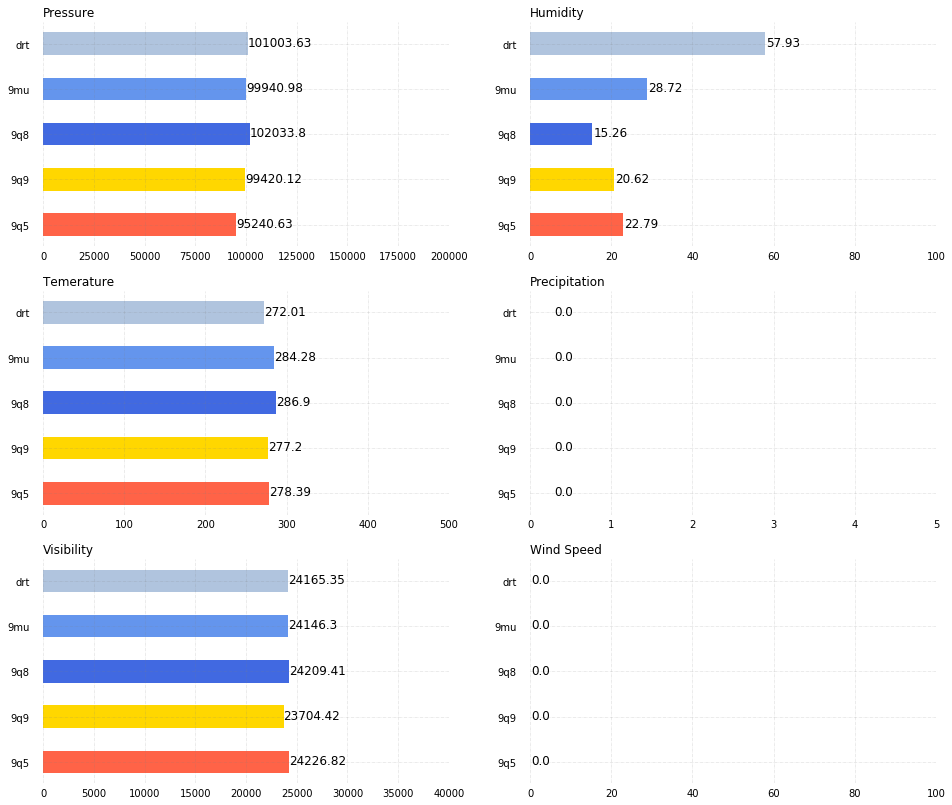

In [14]:
lines = ssc.socketTextStream("orion03", 12889)
parsed_weather_info = lines.map(lambda line: parseLine(line)).filter(lambda val: val is not None) # geo -> (6 features)
updated_metric = parsed_weather_info.updateStateByKey(update_metric) # geo -> (6 features)
metric_mean = updated_metric.map(lambda val: (val[0], cal_mean(val[1]))) # (geo -> 6 feature means)

metric_mean.foreachRDD(lambda rdd: plot_rdd(rdd))
ssc.start()


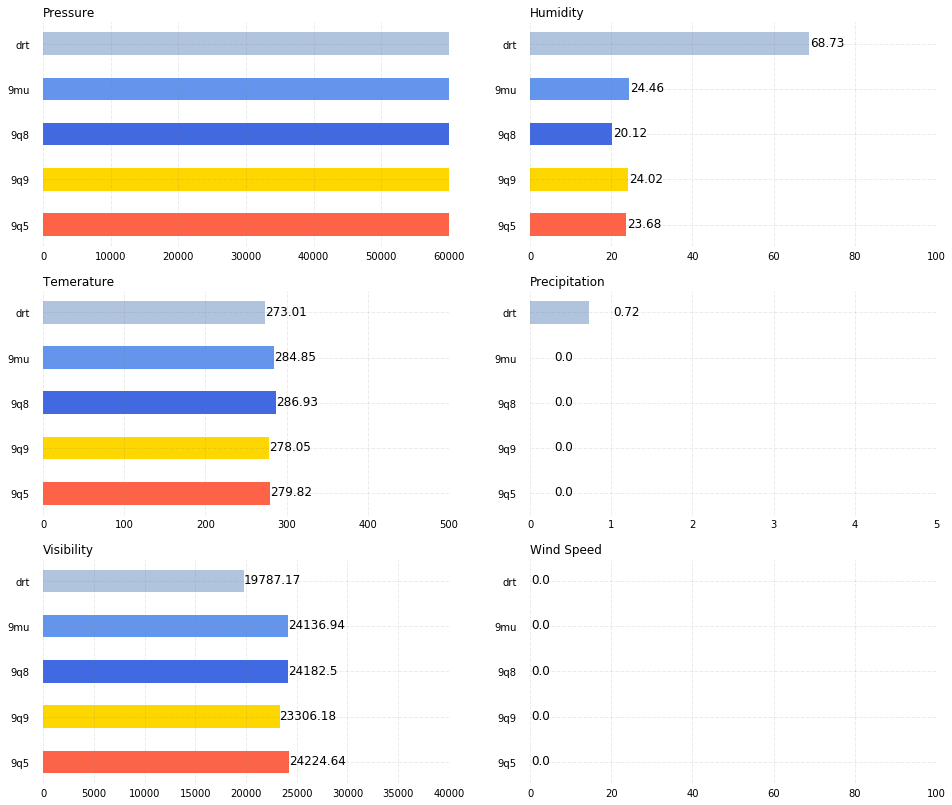

-------------------------------------------
Time: 2020-12-11 01:56:02
-------------------------------------------
('drt', (100966.83695652174, 68.56929347826087, 272.8719742527206, 0.6777626811594203, 19942.824976049676, 0.0))
('9q8', (102307.23388172522, 21.211649622054246, 286.944762596713, 0.0003334815473543797, 24185.438492218385, 0.0))
('9q5', (95603.54557405785, 23.690184049079754, 280.25411120070464, 0.0, 24224.768874670932, 0.0))
('9mu', (99959.25703158806, 23.90350497620078, 285.0435496365246, 5.4089138900908696e-05, 24142.402000259186, 0.0))
('9q9', (99729.11071744908, 24.617803365810452, 278.3235804517307, 0.0, 23325.37340253323, 0.0))



In [8]:
ssc.stop(stopSparkContext=False)
